### 기본 아이디어 : Q러닝을 목표 18개로 나누어서 실행

- Q러닝은 off-policy이므로 exploration / exploitation을 나눠 실행할 수 있다.

- 각각의 목표에 따른 Q-Tables를 만들어서 학습시키고

 Q-Table에 따른 Greedy 정책을 통해서 순차적 task를 수행

 구석진 테이블에 접근이 어려워서 -> 시작점을 랜덤으로 해서 탐색하도록 함
 

- 빠른 exploration을 위해서 시작위치를 랜덤하게 정해줌  
(단순히 랜덤이동이면 시작 위치에서 멀어질수록 탐색확률이 지수적으로 감소하기 때문)
\+ 시작점으로 수렴하는 Q-Table을 만들기 어려우니까

In [22]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [23]:
import random
from string import ascii_uppercase
# from draw_utils_2 import * 
# from pyglet.gl import *
import numpy as np
import pandas as pd
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import copy
import time

In [24]:
device_name = tf.test.gpu_device_name()
print(device_name)

/device:GPU:0


# Exploration Loop
 -> 목표 : 모든 Q_Table 수렴
 

In [25]:
Q_tables = np.zeros((18, 10, 9, 4))

In [26]:
# reward
move_reward = -1 
obs_reward = -10          # 한 번 장애물에 부딪치면, 10번에 1번정도만 장애물쪽에 이동하도록 함
miss_target_reward = -50  # 비어있는 방에 들어가면 -보상을 준다.
goal_reward = 1000        # Q-value의 빠른 수렴을 위해 넉넉하게 리워드를 부여
# print('reward:' , move_reward, obs_reward, goal_reward) 
inds = list(ascii_uppercase)[:17]  # 클래스 활용이 미숙해 전역변수로 변환
inds.append("T")     # T-state (최종 목적지=시작 목적지)를 추가해 줌 (box.csv에도 추가함)
Q_table_name_lst = inds
print(inds)
Q_tables = [] #Q_table_A : np.zero((10, 9, 4)) 형태의 딕셔너리 혹은 Structure Array 형태로 만들어보고 싶었으나 실패
for Q_table_name in Q_table_name_lst:
    globals()["Q_table_{}".format(Q_table_name)] = np.zeros((10, 9, 4)) 
    Q_tables.append(globals()["Q_table_{}".format(Q_table_name)]) 
#일단 완전히 초기화된 Q-Table들의 리스트인 Q-Tables를 만듬, 그냥 np.zeros((18, 10, 9, 4)) 해도 됐을듯 ㅠㅠ
print(len(Q_tables))
local_path = '/content/drive/MyDrive/git_path_finding/path-finding-rl' #구글 코랩용
# local_path = '/home/ogangza/chang_path_finding/path-finding-rl' #GCP용

['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'T']
18


In [27]:
box_data = pd.read_csv(os.path.join(local_path, "./data/box.csv"))

In [28]:
box_coor_index =[]
for i in range(len(box_data)):
    box_coor_index.append([box_data['row'][i], box_data['col'][i]])
print(box_coor_index)

[[5, 0], [4, 0], [3, 0], [2, 0], [0, 0], [0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [0, 6], [0, 7], [0, 8], [2, 8], [3, 8], [4, 8], [5, 8], [9, 4]]


### Q-Tables의 인덱스 = box_coor_index의 인덱스

In [29]:
class Simulator_exploration:  #단순 탐색을 위한 환경
    def __init__(self):
        '''
        height : 그리드 높이
        width : 그리드 너비 
        inds : A ~ Q alphabet list
        '''
        # Load train data
        self.files = pd.read_csv(os.path.join(local_path, "./data/Q_Finder.csv")) #각각 A부터 T까지 하나를 목표로하는 csv파일을 만듬
        self.height = 10 #세로 10
        self.width = 9 # 가로 9  #A~Q까지 알파벳(target) 선언
        self.failcount = 0
        self.successcount = 0
    def set_box(self):
        '''
        아이템들이 있을 위치를 미리 정해놓고 그 위치 좌표들에 아이템이 들어올 수 있으므로 그리드에 100으로 표시한다.
        데이터 파일에서 이번 에피소드 아이템 정보를 받아 가져와야 할 아이템이 있는 좌표만 -100으로 표시한다.
        self.local_target에 에이전트가 이번에 방문해야할 좌표들을 저장한다.
        따라서 가져와야하는 아이템 좌표와 end point 좌표(처음 시작했던 좌표로 돌아와야하므로)가 들어가게 된다.
        '''
        box_data = pd.read_csv(os.path.join(local_path, "./data/box_PQ.csv"))

        # 물건이 들어있을 수 있는 경우
        for box in box_data.itertuples(index = True, name ='Pandas'):  #판다스 데이터를 튜플로 iter해준 것 같다. 행/열 위치정보로 각 알파벳이 표시됨
            self.grid[getattr(box, "row")][getattr(box, "col")] = 100   #아이템이 없는 경우 100

        # 물건이 실제 들어있는 경우
        order_item = list(set(inds) & set(self.items))
        order_csv = box_data[box_data['item'].isin(order_item)]
        for order_box in order_csv.itertuples(index = True, name ='Pandas'):
            self.grid[getattr(order_box, "row")][getattr(order_box, "col")] = -100 # 아이템이 있는 경우 -100 <- 값이 지정되면 리턴으로 사용가능?
            # local target에 가야 할 위치 좌표 넣기
            self.local_target.append(
                [getattr(order_box, "row"),
                 getattr(order_box, "col")]
                )# 타겟 위치 지정 완료
            # print(order_box)
            
        # print(self.local_target)
        # self.local_target.append([9,4])  # 마지막 위치를 추가해주지 않음

        # 알파벳을 Grid에 넣어서 -> grid에 2Dconv 적용 가능

    def set_obstacle(self):
        '''
        장애물이 있어야하는 위치는 미리 obstacles.csv에 정의되어 있다. 이 좌표들을 0으로 표시한다.
        '''
        obstacles_data = pd.read_csv(os.path.join(local_path, "./data/obstacles.csv"))
        for obstacle in obstacles_data.itertuples(index = True, name ='Pandas'):
            self.grid[getattr(obstacle, "row")][getattr(obstacle, "col")] = 0 #장애물 행,열 지정

    def reset(self, epi):
        '''
        reset()은 첫 스텝에서 사용되며 그리드에서 에이전트 위치가 start point에 있게 한다.

        :param epi: episode, 에피소드 마다 가져와야 할 아이템 리스트를 불러올 때 사용
        :return: 초기셋팅 된 그리드
        :rtype: numpy.ndarray
        _____________________________________________________________________________________
        items : 이번 에피소드에서 가져와야하는 아이템들
        terminal_location : 현재 에이전트가 찾아가야하는 목적지
        local_target : 한 에피소드에서 찾아가야하는 아이템 좌표, 마지막 엔드 포인트 등의 위치좌표들
        actions: visualization을 위해 에이전트 action을 저장하는 리스트
        curloc : 현재 위치
        '''

        # initial episode parameter setting
        self.epi = epi
        self.items = list(self.files.iloc[self.epi])[0]
        self.cumulative_reward = 0
        self.terminal_location = None
        self.local_target = []
        self.actions = [] # 정책에 따라 시간 순서대로 action 리스트에 append해주면 될듯

        # initial grid setting
        self.grid = np.ones((self.height, self.width), dtype="float16") #초기는 전부0

        # set information about the gridworld
        self.set_box() #빈박스 + 타겟 박스
        self.set_obstacle() #장애물

        # start point를 grid에 표시
        self.curloc = [np.random.randint(10), np.random.randint(9)] #시작 위치 초기화 (랜덤 위치)
        # obstacle, target 등의 위치를 빼고 시작한다면 더 빠른 수렴이 가능하겠지만, 어차피 그 위치의 q-value는 사용될리 없으므로 완전 랜덤으로 해줌
        self.grid[int(self.curloc[0])][int(self.curloc[1])] = -5       
        
        self.done = False
        
        return self.grid

    def apply_action(self, action, cur_x, cur_y):
        '''
        에이전트가 행한 action대로 현 에이전트의 위치좌표를 바꾼다.
        action은 discrete하며 4가지 up,down,left,right으로 정의된다.
        
        :param x: 에이전트의 현재 x 좌표
        :param y: 에이전트의 현재 y 좌표
        :return: action에 따라 변한 에이전트의 x 좌표, y 좌표
        :rtype: int, int
        '''
        new_x = cur_x
        new_y = cur_y
        # up
        if action == 0:
            if new_x in [6,5,4,3,2] and new_y in [0,8]:
                pass
            else:
                new_x = cur_x - 1
        # down
        elif action == 1:
            if new_x in [1,2,3,4,5] and new_y in [0,8]:
                pass
            else:
                new_x = cur_x + 1
        # left
        elif action == 2:
            if new_y in [ i for i in range(1, 9) ] and new_x == 0:
                pass
            else:
                new_y = cur_y - 1
        # right
        else:
            if new_y in [i for i in range(8)] and new_x ==0:
                pass
            else:
                new_y = cur_y + 1

        return int(new_x), int(new_y)
    


    def get_reward(self, new_x, new_y, out_of_boundary):
        '''
        get_reward함수는 리워드를 계산하는 함수이며, 상황에 따라 에이전트가 action을 옳게 했는지 판단하는 지표가 된다.

        :param new_x: action에 따른 에이전트 새로운 위치좌표 x
        :param new_y: action에 따른 에이전트 새로운 위치좌표 y
        :param out_of_boundary: 에이전트 위치가 그리드 밖이 되지 않도록 제한
        :return: action에 따른 리워드
        :rtype: float
        '''

        # 바깥으로 나가는 경우
        if any(out_of_boundary):
            reward = obs_reward
                       
        else:
            # 장애물에 부딪히는 경우 
            if self.grid[new_x][new_y] == 0:
                reward = obs_reward  

            # 현재 목표에 도달한 경우
            elif new_x == self.terminal_location[0] and new_y == self.terminal_location[1]:
                reward = goal_reward

            # 그냥 움직이는 경우 
            else:
                reward = move_reward

        return reward

    def step(self, action):
        ''' 
        에이전트의 action에 따라 step을 진행한다.
        action에 따라 에이전트 위치를 변환하고, action에 대해 리워드를 받고, 어느 상황에 에피소드가 종료되어야 하는지 등을 판단한다.
        에이전트가 endpoint에 도착하면 gif로 에피소드에서 에이전트의 행동이 저장된다.

        :param action: 에이전트 행동
        :return:
            grid, 그리드
            reward, 리워드
            cumulative_reward, 누적 리워드
            done, 종료 여부
            goal_ob_reward, goal까지 아이템을 모두 가지고 돌아오는 finish율 계산을 위한 파라미터

        :rtype: numpy.ndarray, float, float, bool, bool/str

        (Hint : 시작 위치 (9,4)에서 up말고 다른 action은 전부 장애물이므로 action을 고정하는 것이 좋음)
        '''
        # print(self.local_target)
        self.terminal_location = self.local_target[0]
        cur_x,cur_y = self.curloc
        self.actions.append((cur_x, cur_y))

        goal_ob_reward = False
        
        new_x, new_y = self.apply_action(action, cur_x, cur_y)

        out_of_boundary = [new_x < 0, new_x >= self.height, new_y < 0, new_y >= self.width]

        # 바깥으로 나가는 경우 종료
        if any(out_of_boundary):
            self.done = True
            goal_ob_reward = True
            self.failcount += 1 # 실패 카운터
        else:
            # 장애물에 부딪히는 경우 종료
            if self.grid[new_x][new_y] == 0:
                self.done = True
                goal_ob_reward = True
                self.failcount += 1 # 실패 카운터

            # 현재 목표에 도달한 경우, 다음 목표설정
            elif new_x == self.terminal_location[0] and new_y == self.terminal_location[1]:
                self.successcount +=1 # 성공 카운터

                # end point 일 때
                # if [new_x, new_y] == [9,4]:
                self.done = True # 목표에 도착하면 바로 done 수행

                # self.local_target.remove(self.local_target[0]) 
                # self.grid[cur_x][cur_y] = 1
                # self.grid[new_x][new_y] = -5
                goal_ob_reward = True
                self.curloc = [new_x, new_y]
            else:
                # 그냥 움직이는 경우 
                self.grid[cur_x][cur_y] = 1
                self.grid[new_x][new_y] = -5
                self.curloc = [new_x,new_y]
                
        reward = self.get_reward(new_x, new_y, out_of_boundary)
        self.cumulative_reward += reward

        # if self.done == True:
        #     if [new_x, new_y] == [9, 4]: #초기위치로 도달했을 때,
        #         if self.terminal_location == [9, 4]: # 목표와 같을때만 gif로 만들어줌
        #             # 완료되면 GIFS 저장
        #             goal_ob_reward = 'finish'
        #             height = 10
        #             width = 9
        #             display = Display(visible=False, size=(width, height))
        #             display.start()
        #
        #             start_point = (9, 4)
        #             unit = 50
        #             screen_height = height * unit
        #             screen_width = width * unit
        #             log_path = "./logs"
        #             data_path = "./data"
        #             render_cls = Render(screen_width, screen_height, unit, start_point, data_path, log_path)
        #             for idx, new_pos in enumerate(self.actions):
        #                 render_cls.update_movement(new_pos, idx+1)
        #
        #             render_cls.save_gif(self.epi)
        #             render_cls.viewer.close()
        #             display.stop()
        # 코랩환경이라 그림그리기는 주석처리함
        return self.grid, reward, self.cumulative_reward, self.done, goal_ob_reward



            


In [30]:
class QAgent_exploration():
    def __init__(self):
        self.eps = 0.0
        self.eps_decay = 0.00
    # 랜덤한 위치 -> 굳이 입실론을 통해 탐색하지 않아도 모든 지점에서 시작할 확률이 같으므로 입실론은 무의미
    
    def select_action(self, curloc, index):
        # Q-table은 단순 그리디로 이동, 목표에 따라 Q-Tables에서 인덱스를 알아야하므로 인덱스를 인수로 추가해줌
        x, y = curloc
        coin = random.random()
        if coin < self.eps:
            action = random.randint(0,3)
        else:
            action_val = Q_tables[index][x,y,:] # 목표의 인덱스 = 목표의 Q-Table
            action = np.argmax(action_val)
        return action

    def update_table(self, transition, index):
        s, a, r , s_prime = transition
        x, y = s
        next_x, next_y = s_prime
        a_prime = self.select_action(s_prime, index) 
        Q_tables[index][x,y,a] = Q_tables[index][x,y,a] + 0.1*(r + np.max(Q_tables[index][next_x, next_y, :]) - Q_tables[index][x,y,a])
        #Q러닝 업데이트 식을 이용, 마찬가지로 index를 인수로 추가해 table에 접근함

    def anneal_eps(self):
        self.eps -= self.eps_decay
        self.eps = max(self.eps, 0.0) # 만에하나 한번도 못가본 장소가 있을까봐 0.1만 뒀음 (0이라도 상관없을 듯)
 

In [31]:
def main():
    env = Simulator_exploration()
    agent = QAgent_exploration()
    episode = 10000
    files = pd.read_csv(os.path.join(local_path, "./data/Q_Finder.csv"))
    cum_reward_lst=[]
    acc_lst=[]

    for n_epi in range(episode): #에피소드 변수만큼 실행

        for targetidx in range(len(files)): # 목표를 A~T까지 돌아가면서 수행 + 업데이트
            items = list(files.iloc[targetidx])[0]
            done = False
            acount = 0
            env.reset(targetidx)
            while not done: # 한 에피소드가 끝날때 까지
                s = env.curloc
                a = agent.select_action(s, targetidx)
                acount += 1
                _, r, cum_reward, done, goal_ob_reward = env.step(a)
                s_prime = env.curloc
                agent.update_table((s, a, r, s_prime), targetidx)
                s = s_prime
            agent.anneal_eps()
        if n_epi % 20 == 0:
            acc = (env.successcount/(env.successcount+env.failcount+0.00001)*100)
            print(f'에피소드 :{n_epi}, 액션 수: {acount}, 리턴: {cum_reward}, 성공율 : {acc:2f} %')
            cum_reward_lst.append(cum_reward)
            acc_lst.append(acc)
            env.successcount = 0
            env.failcount = 0

    return acc_lst, cum_reward_lst

In [32]:
start_time = time.time() #시간 체크
with tf.device('/device:GPU:0'):
    acc_lst, cum_reward_lst = main()

end_time = time.time()
print("time :", round(end_time - start_time, 2))

에피소드 :0, 액션 수: 7, 리턴: -16, 성공율 : 5.555552 %
에피소드 :20, 액션 수: 5, 리턴: -14, 성공율 : 3.055555 %
에피소드 :40, 액션 수: 14, 리턴: -23, 성공율 : 3.055555 %
에피소드 :60, 액션 수: 5, 리턴: -14, 성공율 : 10.277777 %
에피소드 :80, 액션 수: 7, 리턴: -16, 성공율 : 22.777777 %
에피소드 :100, 액션 수: 11, 리턴: 990, 성공율 : 55.555554 %
에피소드 :120, 액션 수: 22, 리턴: -31, 성공율 : 53.333332 %
에피소드 :140, 액션 수: 9, 리턴: -18, 성공율 : 49.999999 %
에피소드 :160, 액션 수: 9, 리턴: 992, 성공율 : 56.944443 %
에피소드 :180, 액션 수: 13, 리턴: 988, 성공율 : 64.999998 %
에피소드 :200, 액션 수: 4, 리턴: 997, 성공율 : 74.722220 %
에피소드 :220, 액션 수: 4, 리턴: 997, 성공율 : 83.333331 %
에피소드 :240, 액션 수: 9, 리턴: 992, 성공율 : 84.722220 %
에피소드 :260, 액션 수: 7, 리턴: 994, 성공율 : 82.777775 %
에피소드 :280, 액션 수: 8, 리턴: 993, 성공율 : 86.111109 %
에피소드 :300, 액션 수: 2, 리턴: 999, 성공율 : 88.611109 %
에피소드 :320, 액션 수: 4, 리턴: -13, 성공율 : 90.555553 %
에피소드 :340, 액션 수: 6, 리턴: 995, 성공율 : 89.999998 %
에피소드 :360, 액션 수: 3, 리턴: 998, 성공율 : 93.055553 %
에피소드 :380, 액션 수: 8, 리턴: 993, 성공율 : 96.111108 %
에피소드 :400, 액션 수: 8, 리턴: 993, 성공율 : 95.555553 %
에피소드 :420, 액션 수: 4

각 Index별로 Q_Table의 정책을 시각화 해줌 

In [19]:
q_lst = Q_tables[17].tolist()
data = np.zeros((10, 9))
for row_idx in range(len(q_lst)):
    row = q_lst[row_idx]
    for col_idx in range(len(row)):
        col = row[col_idx]
        action = np.argmax(col)
        data[row_idx, col_idx] = action
print(data)
#상, 하, 좌, 우 = 0, 1, 2, 3
data_direction = np.where(data == 2., '←', data)
data_direction = np.where(data == 0., '↑', data_direction)
data_direction = np.where(data == 3., '→', data_direction)
data_direction = np.where(data == 1., '↓', data_direction)
data_direction[9,4] = 'S'
data_direction[9,4] = 'G'
# 맨 아래 줄
for i in range(4):
    data_direction[9,i] = '■'
for i in range(5,9):
    data_direction[9,i] = '■'
# 맨 윗 줄
upper_line = 'ⓔⓕⓖⓗⓘⓙⓚⓛⓜ'
for i in range(9):
    data_direction[0,i] = upper_line[i]
# 왼쪽, 오른쪽 줄
left_line = 'ⓓⓒⓑⓐ'
right_line = 'ⓝⓞⓟⓠ'
for i in range(2,6):
    data_direction[i,0] = left_line[i-2]
    data_direction[i,8] = right_line[i-2]
# 중간 장애물
for i in range(3,7):
    data_direction[i,2] = '■'
    data_direction[i,4] = '■'
    data_direction[i,6] = '■'
print(data_direction)

[[1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [3. 1. 3. 1. 1. 1. 1. 1. 2.]
 [3. 3. 3. 1. 2. 1. 2. 2. 2.]
 [3. 1. 2. 1. 2. 1. 2. 1. 2.]
 [3. 1. 2. 1. 2. 1. 2. 1. 2.]
 [3. 1. 2. 1. 2. 1. 2. 1. 2.]
 [1. 1. 1. 1. 1. 1. 2. 1. 2.]
 [3. 3. 3. 1. 1. 1. 2. 1. 2.]
 [3. 0. 2. 3. 1. 2. 2. 2. 2.]
 [0. 0. 0. 0. 0. 2. 0. 0. 0.]]
[['ⓔ' 'ⓕ' 'ⓖ' 'ⓗ' 'ⓘ' 'ⓙ' 'ⓚ' 'ⓛ' 'ⓜ']
 ['→' '↓' '→' '↓' '↓' '↓' '↓' '↓' '←']
 ['ⓓ' '→' '→' '↓' '←' '↓' '←' '←' 'ⓝ']
 ['ⓒ' '↓' '■' '↓' '■' '↓' '■' '↓' 'ⓞ']
 ['ⓑ' '↓' '■' '↓' '■' '↓' '■' '↓' 'ⓟ']
 ['ⓐ' '↓' '■' '↓' '■' '↓' '■' '↓' 'ⓠ']
 ['↓' '↓' '■' '↓' '■' '↓' '■' '↓' '←']
 ['→' '→' '→' '↓' '↓' '↓' '←' '↓' '←']
 ['→' '↑' '←' '→' '↓' '←' '←' '←' '←']
 ['■' '■' '■' '■' 'G' '■' '■' '■' '■']]


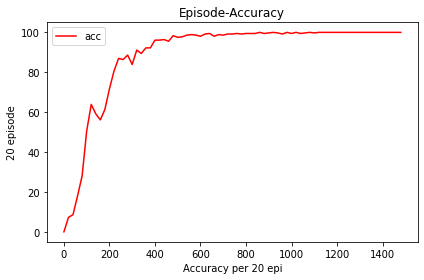

In [ ]:
epilst = [i for i in range(0, 1500, 20)]

plt.plot(epilst, acc_lst, color='red', label='acc')

plt.xlabel('Accuracy per 20 epi')
plt.ylabel('20 episode')
plt.title('Episode-Accuracy')
plt.legend()

plt.tight_layout()

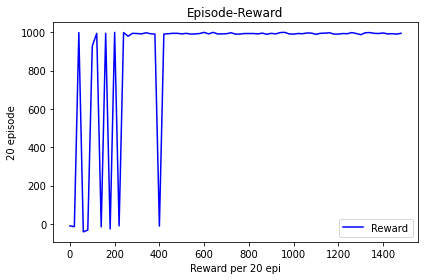

In [ ]:
epilst = [i for i in range(0, 1500, 20)]

plt.plot(epilst, cum_reward_lst, color='blue', label='Reward')

plt.xlabel('Reward per 20 epi')
plt.ylabel('20 episode')
plt.title('Episode-Reward')
plt.legend()

plt.tight_layout()

In [ ]:
# import pickle
# file = open("/content/drive/MyDrive/git_path_finding/path-finding-rl/data/save.txt", "wb") 
# pickle.dump(Q_tables, file)
# file.close

In [ ]:
# with open('Q_tables(20000).pickle', 'wb') as f:
#     pickle.dump(Q_tables, f)

### 피클로 저장할 수 있다고 해서 저장 -> data 폴더에 넣어둠


In [ ]:
# with open('Q_tables(20000).pickle','rb') as f:   
#     Q_tables = pickle.load(f)

# Exploitaition Loop
 -> Test data 사용
 

In [33]:
class Simulator:
    def __init__(self):
        '''
        height : 그리드 높이
        width : 그리드 너비 
        inds : A ~ Q alphabet list
        '''
        # Load train data
        self.files = pd.read_csv(os.path.join(local_path, "./data/factory_order_test.csv"))
        self.height = 10 #세로 10
        self.width = 9 # 가로 9  #A~Q까지 알파벳(target) 선언
        self.failcount = 0
        self.successcount = 0
        self.init_local_target = []
    def set_box(self):
        '''
        아이템들이 있을 위치를 미리 정해놓고 그 위치 좌표들에 아이템이 들어올 수 있으므로 그리드에 100으로 표시한다.
        데이터 파일에서 이번 에피소드 아이템 정보를 받아 가져와야 할 아이템이 있는 좌표만 -100으로 표시한다.
        self.local_target에 에이전트가 이번에 방문해야할 좌표들을 저장한다.
        따라서 가져와야하는 아이템 좌표와 end point 좌표(처음 시작했던 좌표로 돌아와야하므로)가 들어가게 된다.
        '''
        box_data = pd.read_csv(os.path.join(local_path, "./data/box.csv"))

        # 물건이 들어있을 수 있는 경우
        for box in box_data.itertuples(index = True, name ='Pandas'):  #판다스 데이터를 튜플로 iter해준 것 같다. 행/열 위치정보로 각 알파벳이 표시됨
            self.grid[getattr(box, "row")][getattr(box, "col")] = 100   #아이템이 없는 경우 100

        # 물건이 실제 들어있는 경우
        order_item = list(set(inds) & set(self.items))
        order_csv = box_data[box_data['item'].isin(order_item)]
        for order_box in order_csv.itertuples(index = True, name ='Pandas'):
            self.grid[getattr(order_box, "row")][getattr(order_box, "col")] = -100 # 아이템이 있는 경우 -100 <- 값이 지정되면 리턴으로 사용가능?
            # local target에 가야 할 위치 좌표 넣기
            self.local_target.append(
                [getattr(order_box, "row"),
                 getattr(order_box, "col")]
                )# 타겟 위치 지정 완료
            # print(order_box)
        # print(self.local_target)
        self.local_target.append([9,4])  # 마지막 타겟 = 출발위치
        self.init_local_target = copy.deepcopy(self.local_target)
        
        # 알파벳을 Grid에 넣어서 -> grid에 2Dconv 적용 가능

    def set_obstacle(self):
        '''
        장애물이 있어야하는 위치는 미리 obstacles.csv에 정의되어 있다. 이 좌표들을 0으로 표시한다.
        '''
        obstacles_data = pd.read_csv(os.path.join(local_path, "./data/obstacles.csv"))
        for obstacle in obstacles_data.itertuples(index = True, name ='Pandas'):
            self.grid[getattr(obstacle, "row")][getattr(obstacle, "col")] = 0 #장애물 행,열 지정

    def reset(self, epi):
        '''
        reset()은 첫 스텝에서 사용되며 그리드에서 에이전트 위치가 start point에 있게 한다.

        :param epi: episode, 에피소드 마다 가져와야 할 아이템 리스트를 불러올 때 사용
        :return: 초기셋팅 된 그리드
        :rtype: numpy.ndarray
        _____________________________________________________________________________________
        items : 이번 에피소드에서 가져와야하는 아이템들
        terminal_location : 현재 에이전트가 찾아가야하는 목적지
        local_target : 한 에피소드에서 찾아가야하는 아이템 좌표, 마지막 엔드 포인트 등의 위치좌표들
        actions: visualization을 위해 에이전트 action을 저장하는 리스트
        curloc : 현재 위치
        '''

        # initial episode parameter setting
        self.epi = epi
        self.items = list(self.files.iloc[self.epi])[0]
        self.cumulative_reward = 0
        self.terminal_location = None
        self.local_target = []
        self.actions = [] # 정책에 따라 시간 순서대로 action 리스트에 append해주면 될듯


        # initial grid setting
        self.grid = np.ones((self.height, self.width), dtype="float16") #초기는 전부0

        # set information about the gridworld
        self.set_box() #빈박스 + 타겟 박스
        self.set_obstacle() #장애물

        # start point를 grid에 표시
        self.curloc = [9, 4] #시작 위치 초기화 (인덱스 0부터 시작이므로 10번째줄, 5번째 열임)
        self.grid[int(self.curloc[0])][int(self.curloc[1])] = -5       
        
        self.done = False
        
        return self.grid

    def apply_action(self, action, cur_x, cur_y):
        '''
        에이전트가 행한 action대로 현 에이전트의 위치좌표를 바꾼다.
        action은 discrete하며 4가지 up,down,left,right으로 정의된다.
        
        :param x: 에이전트의 현재 x 좌표
        :param y: 에이전트의 현재 y 좌표
        :return: action에 따라 변한 에이전트의 x 좌표, y 좌표
        :rtype: int, int
        '''
        new_x = cur_x
        new_y = cur_y
        # up
        if action == 0:
            if new_x in [6,5,4,3,2] and new_y in [0,8]:
                pass
            else:
                new_x = cur_x - 1
        # down
        elif action == 1:
            if new_x in [1,2,3,4,5] and new_y in [0,8]:
                pass
            else:
                new_x = cur_x + 1
        # left
        elif action == 2:
            if new_y in [ i for i in range(1, 9) ] and new_x == 0:
                pass
            else:
                new_y = cur_y - 1
        # right
        else:
            if new_y in [i for i in range(8)] and new_x ==0:
                pass
            else:
                new_y = cur_y + 1

        return int(new_x), int(new_y)


    def get_reward(self, new_x, new_y, out_of_boundary):
        '''
        get_reward함수는 리워드를 계산하는 함수이며, 상황에 따라 에이전트가 action을 옳게 했는지 판단하는 지표가 된다.

        :param new_x: action에 따른 에이전트 새로운 위치좌표 x
        :param new_y: action에 따른 에이전트 새로운 위치좌표 y
        :param out_of_boundary: 에이전트 위치가 그리드 밖이 되지 않도록 제한
        :return: action에 따른 리워드
        :rtype: float
        '''

        # 바깥으로 나가는 경우
        if any(out_of_boundary):
            reward = obs_reward
                       
        else:
            # 장애물에 부딪히는 경우 
            if self.grid[new_x][new_y] == 0:
                reward = obs_reward  

            # 현재 목표에 도달한 경우
            elif new_x == self.terminal_location[0] and new_y == self.terminal_location[1]:
                reward = goal_reward

            # 그냥 움직이는 경우 
            else:
                reward = move_reward

        return reward

    def step(self, action):
        ''' 
        에이전트의 action에 따라 step을 진행한다.
        action에 따라 에이전트 위치를 변환하고, action에 대해 리워드를 받고, 어느 상황에 에피소드가 종료되어야 하는지 등을 판단한다.
        에이전트가 endpoint에 도착하면 gif로 에피소드에서 에이전트의 행동이 저장된다.

        :param action: 에이전트 행동
        :return:
            grid, 그리드
            reward, 리워드
            cumulative_reward, 누적 리워드
            done, 종료 여부
            goal_ob_reward, goal까지 아이템을 모두 가지고 돌아오는 finish율 계산을 위한 파라미터

        :rtype: numpy.ndarray, float, float, bool, bool/str

        (Hint : 시작 위치 (9,4)에서 up말고 다른 action은 전부 장애물이므로 action을 고정하는 것이 좋음)
        '''
        
        ###

        
        
        
        
        
        self.terminal_location = self.local_target[0]
     
        cur_x,cur_y = self.curloc
        self.actions.append((cur_x, cur_y))

        goal_ob_reward = False
        
        new_x, new_y = self.apply_action(action, cur_x, cur_y)

        out_of_boundary = [new_x < 0, new_x >= self.height, new_y < 0, new_y >= self.width]

        # 바깥으로 나가는 경우 종료
        if any(out_of_boundary):
            self.done = True
            goal_ob_reward = True
            self.failcount += 1
            
        else:
            # 장애물에 부딪히는 경우 종료
            if self.grid[new_x][new_y] == 0:
                self.done = True
                goal_ob_reward = True
                self.failcount += 1
               
            # 현재 목표에 도달한 경우, 다음 목표설정
            elif new_x == self.terminal_location[0] and new_y == self.terminal_location[1]:
                

                # end point 일 때
                if [new_x, new_y] == [9,4]:
                    self.done = True # 마지막 목표가 설정되면 done을 True로 설정
                    self.successcount +=1

                self.local_target.remove(self.local_target[0]) # 목표 달성시 목표 맨 앞 리스트를 지워준다.
                self.grid[cur_x][cur_y] = 1
                self.grid[new_x][new_y] = -5
                goal_ob_reward = True
                self.curloc = [new_x, new_y]
            else:
                # 그냥 움직이는 경우 
                self.grid[cur_x][cur_y] = 1
                self.grid[new_x][new_y] = -5
                self.curloc = [new_x,new_y]
               
                
        reward = self.get_reward(new_x, new_y, out_of_boundary)
        self.cumulative_reward += reward
# #         print("local_taget",self.local_target)
# #         print("terminal_location",self.terminal_location)
#         if self.done == True:
#             if [new_x, new_y] == [9, 4]: #초기위치로 도달했을 때,
#                 if self.terminal_location == [9, 4]: # 목표와 같을때만 gif로 만들어줌
#                     # 완료되면 GIFS 저장
#                     goal_ob_reward = 'finish'
#                     height = 10
#                     width = 9
#                     display = Display(visible=False, size=(width, height))
#                     display.start()
#                     start_point = (9, 4)
#                     unit = 50
#                     screen_height = height * unit
#                     screen_width = width * unit
#                     log_path = "./logs"
#                     data_path ="./data"
#                     print(self.init_local_target)
#                     render_cls = Render(self.init_local_target, screen_width, screen_height, unit, start_point, data_path, log_path)
#                     for idx, new_pos in enumerate(self.actions):
#                         render_cls.update_movement(new_pos, idx+1)
        
#                     render_cls.save_gif(self.epi, '_성공')
#                     render_cls.viewer.close()
#                     display.stop()
#         else:
                    
#                     # 완료되면 GIFS 저장
#                     goal_ob_reward = 'finish'
#                     height = 10
#                     width = 9
#                     display = Display(visible=False, size=(width, height))
#                     display.start()
#                     start_point = (9, 4)
#                     unit = 50
#                     screen_height = height * unit
#                     screen_width = width * unit
#                     log_path = "./logs"
#                     data_path ="./data"
                    
#                     render_cls = Render(self.init_local_target, screen_width, screen_height, unit, start_point, data_path, log_path)
#                     for idx, new_pos in enumerate(self.actions):
#                         render_cls.update_movement(new_pos, idx+1)

#                     render_cls.save_gif(self.epi, '_실패')
#                     render_cls.viewer.close()
#                     display.stop()

        return self.grid, reward, self.cumulative_reward, self.done, goal_ob_reward



            


환경은 원본코드 거의 그대로 사용, 

전역변수 선언해준 것

factory_order_test만 불러옴

사실 완성 Q-Table이 있으니 test나 train이나 그게 그거임

In [34]:
class QAgent_exploitation(): #테스트 클래스, 마찬가지로 입실론은 안써도 된다.
    def __init__(self):
        self.eps = 0.0  # exploitation만 하면됨
        self.eps_decay = 0.00

    
    def select_action(self, curloc, index):
        # index인수로 받아서 접근만 추가함
        x, y = curloc
        coin = random.random()
        if coin < self.eps:
            action = random.randint(0,3)
        else:
            action_val = Q_tables[index][x,y,:]
            action = np.argmax(action_val)
        return action

    def update_table(self, transition, index):
        s, a, r , s_prime = transition
        x, y = s
        next_x, next_y = s_prime
        a_prime = self.select_action(s_prime, index) 
        # Q_tables[index][x,y,a] = Q_tables[index][x,y,a] + 0.1*(r + np.max(Q_tables[index][next_x, next_y, :]) - Q_tables[index][x,y,a])
        # table은 더이상 업데이트 안해도됨, Q-Table만 따라 이동하면 된다.


    def anneal_eps(self):
        self.eps -= self.eps_decay
        self.eps = max(self.eps, 0.0)

In [35]:
def main():
    env = Simulator()
    agent = QAgent_exploitation()
    episode = len(env.files)
    allacount = 0
    for n_epi in range(episode):
        alst = []
        acount = 0
        done = False
        env.reset(n_epi)
#         print(env.local_target)
        while not done: # 에피소드가 끝날때 까지 반복
            targetidx = box_coor_index.index(env.local_target[0])
            s = env.curloc
            a = agent.select_action(s, targetidx)
            alst.append(a) #액션들을 alst에 모아둠 -> 나중에 시각화하려구
            acount += 1 #액션 수
            allacount +=1
            _, r, cum_reward, done, goal_ob_reward = env.step(a)
            s_prime = env.curloc
            agent.update_table((s, a, r, s_prime), targetidx)
            s = s_prime
        agent.anneal_eps()
        print(f'episode :{n_epi}, Steps: {acount}, Return: {cum_reward}, Finish Rate : {(env.successcount/(env.successcount+env.failcount+0.00001)*100):.2f} %') # 0 division오류로 인해 작은값을 분모에 더해줌
        if n_epi%20 ==0:
            print(alst) #20회마다 액션리스트만 print
    print(f'평균 Step : {allacount/n_epi}')

In [36]:
with tf.device('/device:GPU:0'):
    main()

episode :0, Steps: 44, Return: 7964, Finish Rate : 100.00 %
[0, 0, 2, 2, 2, 0, 0, 2, 3, 0, 2, 3, 0, 0, 2, 3, 0, 3, 3, 0, 1, 3, 3, 0, 1, 3, 3, 3, 0, 1, 2, 1, 1, 1, 3, 2, 1, 1, 1, 2, 2, 2, 1, 1]
episode :1, Steps: 42, Return: 7966, Finish Rate : 100.00 %
episode :2, Steps: 42, Return: 7966, Finish Rate : 100.00 %
episode :3, Steps: 44, Return: 7964, Finish Rate : 100.00 %
episode :4, Steps: 42, Return: 6965, Finish Rate : 100.00 %
episode :5, Steps: 44, Return: 7964, Finish Rate : 100.00 %
episode :6, Steps: 44, Return: 6963, Finish Rate : 100.00 %
episode :7, Steps: 44, Return: 7964, Finish Rate : 100.00 %
episode :8, Steps: 42, Return: 6965, Finish Rate : 100.00 %
episode :9, Steps: 44, Return: 7964, Finish Rate : 100.00 %
episode :10, Steps: 44, Return: 7964, Finish Rate : 100.00 %
episode :11, Steps: 44, Return: 7964, Finish Rate : 100.00 %
episode :12, Steps: 46, Return: 7962, Finish Rate : 100.00 %
episode :13, Steps: 46, Return: 7962, Finish Rate : 100.00 %
episode :14, Steps: 44,

In [ ]:
def actiontocoordinate(actionlist):
    coordlst = []
    x, y = (9, 4)
    for i in actionlist:
        if i == 0: # 위로 이동
            x = x - 1
            coordlst.append((x, y))
        # down
        elif i == 1: # 아래 00 1
            x = x + 1
            coordlst.append((x, y))
        # left
        elif i == 2: # 왼쪽
            y = y - 1
            coordlst.append((x, y))
        # right
        elif i == 3: # 오른쪽
            y = y + 1
            coordlst.append((x, y))
    print(coordlst)

In [ ]:
actiontocoordinate([0, 0, 2, 2, 2, 0, 0, 2, 0, 0, 0, 0, 0, 1, 3, 3, 0, 1, 3, 3, 3, 0, 3, 1, 3, 1, 3, 2, 2, 2, 1, 1, 1, 1, 1, 2, 1, 1])

[(8, 4), (7, 4), (7, 3), (7, 2), (7, 1), (6, 1), (5, 1), (5, 0), (4, 0), (3, 0), (2, 0), (1, 0), (0, 0), (1, 0), (1, 1), (1, 2), (0, 2), (1, 2), (1, 3), (1, 4), (1, 5), (0, 5), (0, 6), (1, 6), (1, 7), (2, 7), (2, 8), (2, 7), (2, 6), (2, 5), (3, 5), (4, 5), (5, 5), (6, 5), (7, 5), (7, 4), (8, 4), (9, 4)]


# 회고 및 더 나아가야 할 방향

예상한대로 완전히 수렴한 여러 개의 Q-Table의 성능은 완벽했다.

혹은 상태, 액션, 변수가 적다는 점에서 
MDP를 아는 상황을 상정해 수렴하는 상태가치 table만 알 수 있어도
더 빠른 최적 정책을 찾을 수 있을 것 같다.

목표가 더 많아지는 경우 각각의 목표에 따라 Q-Table을 만들어 해결할 수 있을 것으로 예상되지만

예측할 수 없는 변수들로 인해 전이 확률이 변화하거나 상태, 액션등이 많아서 테이블 전부 저장하기 힘들어진다면 단순 알고리즘보다 뉴럴넷을 사용하는 것이 연산량 대비 성능 비(?) 가 좋아지는 시점이 올 것으로 예상되지만 table기반 강화학습도 여전히 강력함을 확인 할 수 있었다.

이런 경우 뉴럴넷을 연결한다면 분리해서 학습 후 취합하는 방식과 하나의 뉴럴넷으로 피쳐들 간에 관계들을 파악하는 것 중 어느 것이 더 좋을지 모르겠다.

FC레이어들로 각각 학습시킨뒤에 선형결합으로 관계성을 파악하는 방식이 좋아보이긴 하는데... 잘 될지는 모르겠다.

완벽하게 통제가능한 상황에서, 외부 요인이 전혀 없다고 가정하면
이렇게 데이터들을 미리 구해놓는 방식이 유리할 수 있으나, 특정 목표를 향해 가는 시간 Δt동안 환경이 변화하거나 하는 상황에 유연한 대처가 어려운 단점이 있다.

예를들어 같은 목표를 가지는 에이전트가 여러 개라던가, 그리드 상에 랜덤하게 장애물이 추가되거나 하는 상황을 가정하면, 그때마다 모든 state에 대한 계산을 다시 해줘야하는 것이다. 이 경우에는 Multiple Q모델이 더 유연성을 가진다고 생각할 수 있을 것이다.

##추가 계획

일단 일정 주기마다 업데이트한 Q-table을 validation set에 지속적으로 결과를 확인해보는 방식을 통해 적정 Q_table 수렴에 걸리는 episode와 수렴에 걸리는 시간, 사용된 램 용량 등을 체크해서 다른 분들의 모델과 비교해보는게 좋을 것 같다.

GPU를 쓰지않아도 속도가 그렇게 느린건 아니었으나 
정확한비교를 위해, GPU를 사용해서 학습시킬 수 있도록 해봐야할 것 같다.

또한 임의의 목표 A, B, C를 따로 잡고 Q러닝을 학습하는 것이 아닌 train set으로 학습시켰을때의 차이도 궁금하다.

휴리스틱 알고리즘 적용 : 좌수법에서 사용한 타겟 가져오기, 첫 행동 위로 고정 등

## 궁금한 점들

보상을 몇으로 설정해주는게 가장 학습이 빠른지 궁금하다.
아마도... 선택할 액션의 숫자와 최적해(이동 수), grid의 가로, 세로 수에 따른 함수로 나타날 것으로 예상은 된다만,

만약 Target의 위치가 랜덤하게 생성된다면? 모든 State에 대한 학습을 하면 되지 않을까?

혹은 Target의 위치가 특정되지 않아 자유이동하는 물체라면 어떨까? 뜬구름 잡는건 말도안되니 5칸정도 이내에 trail을 남긴다면 어떤 방식으로 학습이 될까 궁금하다. 이런 경우라면 뉴럴넷이 더 유리할 수도 있을꺼같은데... 